In [5]:
%pip install pandas
import pandas as pd

# Load datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Preview data
print(customers.head())
print(products.head())
print(transactions.head())


  Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl (11.6 MB)
Using cached pytz-2024.2-py2.py3-none-any.whl (508 kB)
Using cached tzdata-2025.1-py2.py3-none-any.whl (346 kB)



[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3       

In [6]:
# Check for missing values
print("Customers missing values:\n", customers.isnull().sum())
print("Products missing values:\n", products.isnull().sum())
print("Transactions missing values:\n", transactions.isnull().sum())

# Remove duplicates
customers = customers.drop_duplicates()
transactions = transactions.drop_duplicates()

# Validate TotalValue = Quantity * Price
transactions['CalculatedTotal'] = transactions['Quantity'] * transactions['Price']
invalid_transactions = transactions[transactions['TotalValue'] != transactions['CalculatedTotal']]
print(f"Invalid transactions: {len(invalid_transactions)}")

Customers missing values:
 CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64
Products missing values:
 ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64
Transactions missing values:
 TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64
Invalid transactions: 88


In [7]:
# Merge Transactions with Customers and Products
merged_data = transactions.merge(customers, on='CustomerID', how='left')
merged_data = merged_data.merge(products, on='ProductID', how='left')


  Using cached matplotlib-3.10.0-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached contourpy-1.3.1-cp311-cp311-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.55.6-cp311-cp311-win_amd64.whl.metadata (169 kB)
  Using cached kiwisolver-1.4.8-cp311-cp311-win_amd64.whl.metadata (6.3 kB)
Using cached matplotlib-3.10.0-cp311-cp311-win_amd64.whl (8.0 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached contourpy-1.3.1-cp311-cp311-win_amd64.whl (219 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.55.6-cp311-cp311-win_amd64.whl (2.2 MB)
Using cached kiwisolver-1.4.8-cp311-cp311-win_amd64.whl (71 kB)



[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


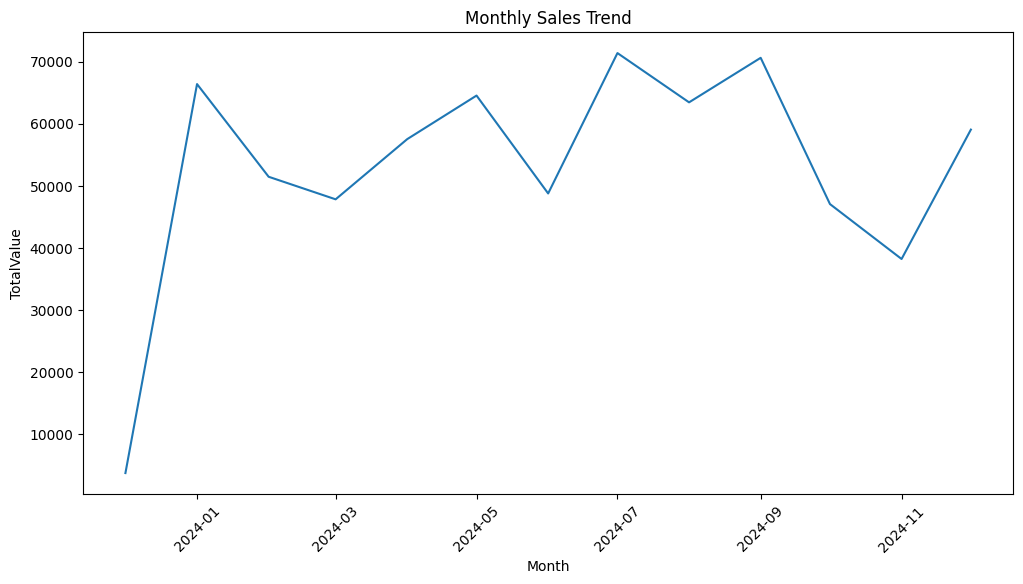

In [10]:
%pip install matplotlib seaborn

import matplotlib.pyplot as plt
import seaborn as sns

# Convert TransactionDate to datetime
merged_data['TransactionDate'] = pd.to_datetime(merged_data['TransactionDate'])

# Option 1: Use Month as string
merged_data['Month'] = merged_data['TransactionDate'].dt.strftime('%Y-%m')  # Format: "2023-01"

# Option 2: Use Month as datetime (first day of the month)
merged_data['Month'] = merged_data['TransactionDate'].dt.to_period('M').dt.to_timestamp()

# Aggregate and sort
monthly_sales = merged_data.groupby('Month')['TotalValue'].sum().reset_index()
monthly_sales = monthly_sales.sort_values('Month')

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='Month', y='TotalValue', data=monthly_sales)
plt.xticks(rotation=45)
plt.title('Monthly Sales Trend')
plt.show()

In [11]:
# Tenure (days since signup)
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
current_date = pd.to_datetime('today')
customers['Tenure'] = (current_date - customers['SignupDate']).dt.days

# Transaction History
transaction_features = transactions.groupby('CustomerID').agg(
    TotalSpend=pd.NamedAgg(column='TotalValue', aggfunc='sum'),
    PurchaseFrequency=pd.NamedAgg(column='TransactionID', aggfunc='nunique'),
    AvgOrderValue=pd.NamedAgg(column='TotalValue', aggfunc='mean')
).reset_index()

# Merge with Customer Data
customer_features = customers.merge(transaction_features, on='CustomerID', how='left')

# One-Hot Encode Region
customer_features = pd.get_dummies(customer_features, columns=['Region'])

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# After merging customer_features:
customer_features = customer_features.fillna(0)

# Select features and scale
features = customer_features.drop(columns=['CustomerID', 'CustomerName', 'SignupDate'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Compute similarity matrix
similarity_matrix = cosine_similarity(scaled_features)

In [14]:
# For each customer in C0001-C0020, get top 3 similar customers
lookalike_map = {}
target_customers = [f'C{str(i).zfill(4)}' for i in range(1, 21)]

for cust_id in target_customers:
    idx = customer_features[customer_features['CustomerID'] == cust_id].index[0]
    scores = list(enumerate(similarity_matrix[idx]))
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)[1:4]  # Exclude self
    lookalike_map[cust_id] = [(customer_features.iloc[i]['CustomerID'], score) for i, score in sorted_scores]

# Convert to DataFrame and save as CSV
lookalike_df = pd.DataFrame(lookalike_map.items(), columns=['CustomerID', 'Lookalikes'])
lookalike_df.to_csv('Lookalike.csv', index=False)

In [15]:
# Recency (days since last transaction)
last_transaction = transactions.groupby('CustomerID')['TransactionDate'].max().reset_index()
last_transaction['Recency'] = (pd.to_datetime('today') - pd.to_datetime(last_transaction['TransactionDate'])).dt.days

# Merge all features
segmentation_features = customer_features.merge(last_transaction[['CustomerID', 'Recency']], on='CustomerID', how='left')

# Select and scale features
X = segmentation_features[['TotalSpend', 'PurchaseFrequency', 'Recency', 'Tenure']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

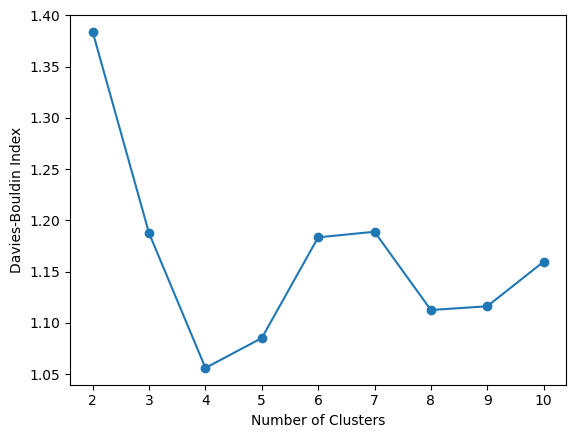

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.impute import SimpleImputer

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_scaled_imputed = imputer.fit_transform(X_scaled)

# Find optimal clusters (2-10)
db_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_scaled_imputed)
    db_scores.append(davies_bouldin_score(X_scaled_imputed, kmeans.labels_))

# Plot DB Index
plt.plot(range(2, 11), db_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.show()

# Final model (example: k=4)
kmeans = KMeans(n_clusters=4, random_state=42).fit(X_scaled_imputed)
segmentation_features['Cluster'] = kmeans.labels_

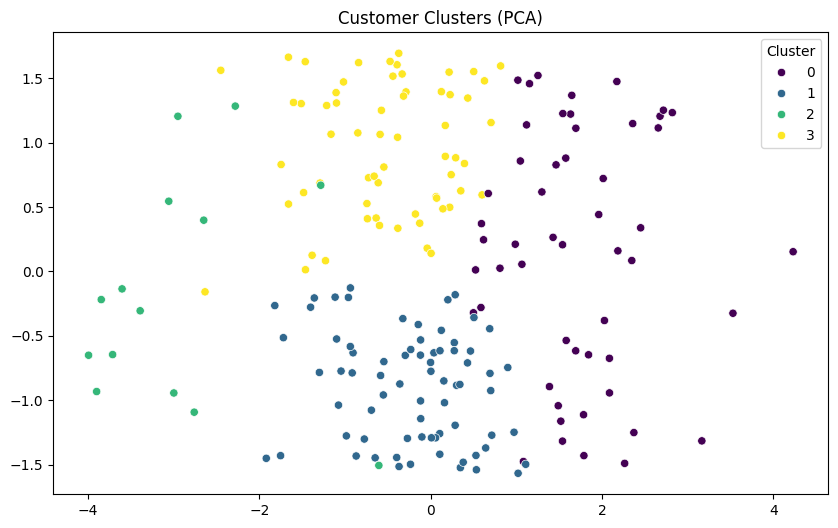

In [19]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_scaled_imputed = imputer.fit_transform(X_scaled)

# Reduce dimensions for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_imputed)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=segmentation_features['Cluster'], palette='viridis')
plt.title('Customer Clusters (PCA)')
plt.show()